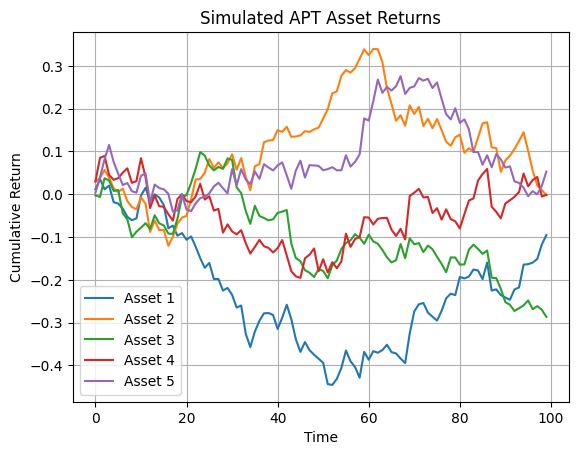

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# Define parameters
n_assets = 5
n_periods = 100
n_factors = 3

# Simulate factor returns
factor_returns = np.random.normal(0, 0.01, size=(n_periods, n_factors))

# Simulate asset factor loadings (betas)
betas = np.random.uniform(0.5, 1.5, size=(n_assets, n_factors))

# Simulate idiosyncratic noise
epsilon = np.random.normal(0, 0.02, size=(n_periods, n_assets))

# Calculate asset returns
returns = factor_returns @ betas.T + epsilon

# Create DataFrame
df_returns = pd.DataFrame(returns, columns=[f'Asset {i+1}' for i in range(n_assets)])

df_returns.cumsum().plot(title='Simulated APT Asset Returns')
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()


[**********************62%*****                  ]  5 of 8 completed

Required packages:
pip install numpy pandas matplotlib seaborn scikit-learn scipy yfinance

Running APT Model Demo...
--------------------------------------------------
Arbitrage Pricing Theory Model Demo
Loading stock data...


[*********************100%***********************]  8 of 8 completed


Loaded data for 8 assets and 4 factors
Date range: 2020-01-03 00:00:00 to 2023-12-29 00:00:00
Estimating factor loadings...
Factor loading estimation completed!


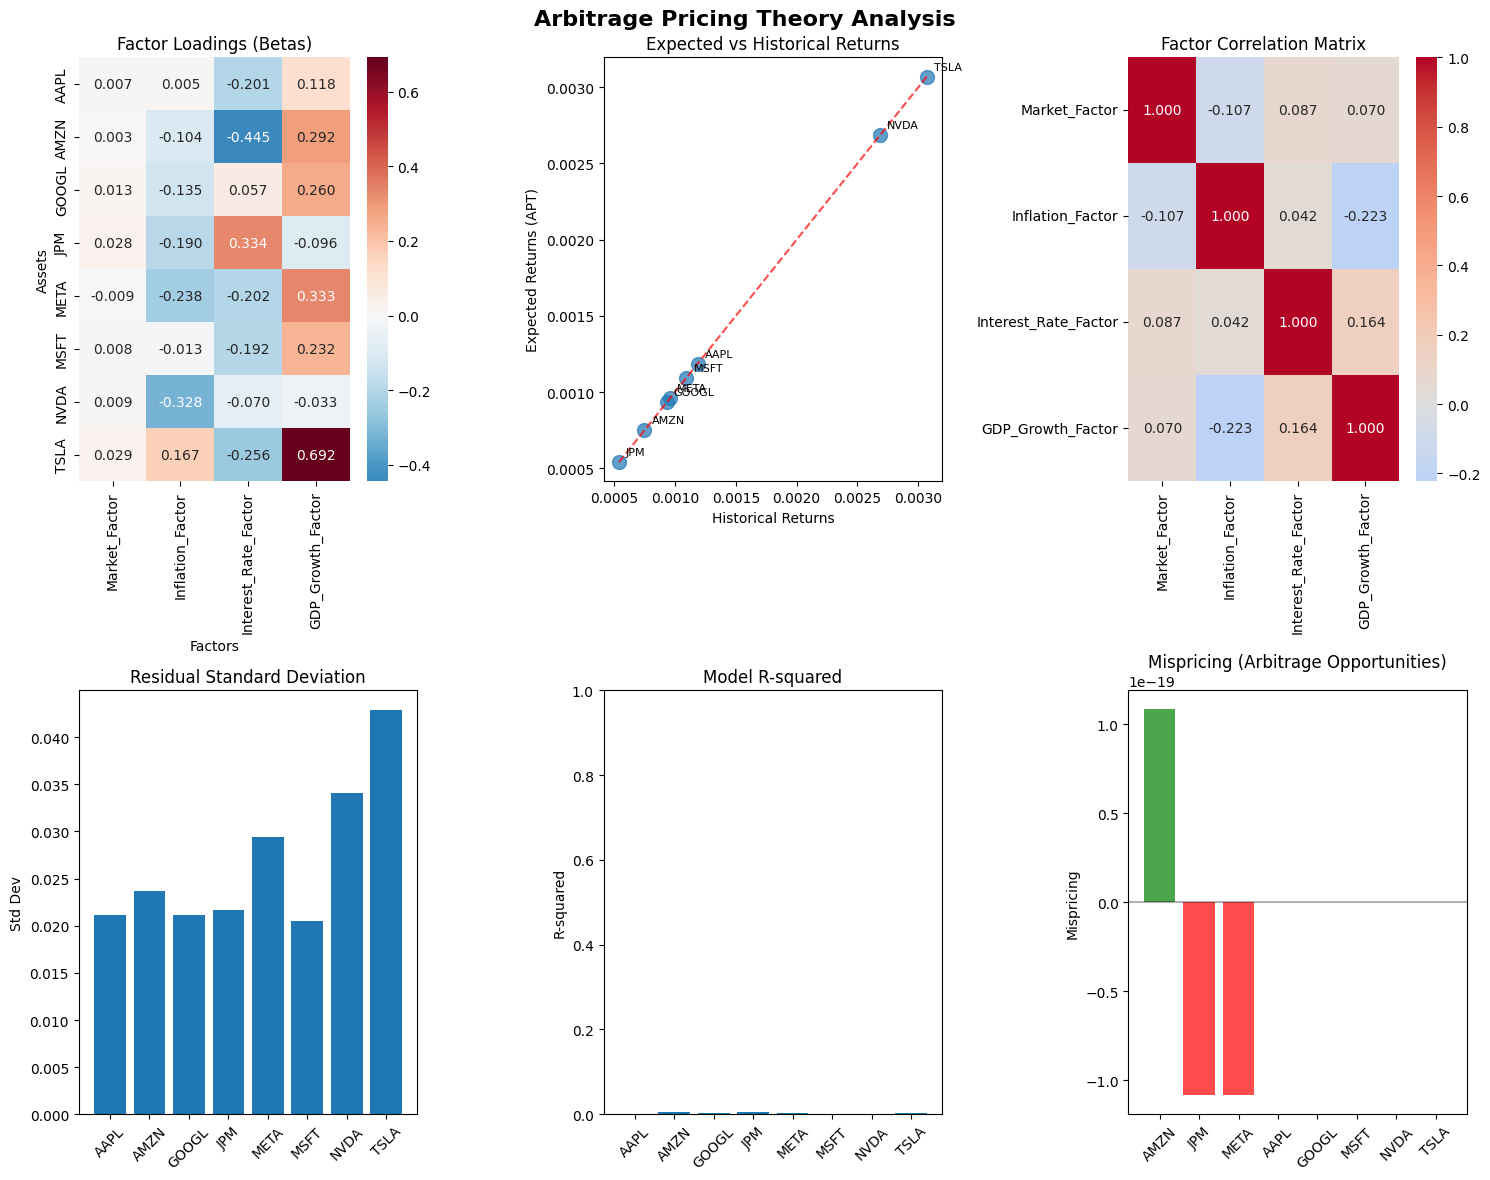

ARBITRAGE PRICING THEORY MODEL REPORT

DATA SUMMARY:
Assets: 8
Factors: 4
Time Period: 2020-01-03 00:00:00 to 2023-12-29 00:00:00
Observations: 1005

FACTOR LOADINGS SUMMARY:
        Market_Factor  Inflation_Factor  Interest_Rate_Factor  \
count        8.000000          8.000000              8.000000   
unique       8.000000          8.000000              8.000000   
top          0.007341          0.004566             -0.200909   
freq         1.000000          1.000000              1.000000   

        GDP_Growth_Factor  
count            8.000000  
unique           8.000000  
top              0.118138  
freq             1.000000  

MODEL FIT STATISTICS:
       R_squared       MSE  Std_Error
AAPL    0.001009  0.000446   0.021125
AMZN    0.004388  0.000561   0.023677
GOOGL   0.003590  0.000444   0.021076
JPM     0.006186  0.000467   0.021607
META    0.003196  0.000865   0.029407
MSFT    0.001872  0.000421   0.020516
NVDA    0.001915  0.001164   0.034111
TSLA    0.003034  0.001833   0.0

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.optimize import minimize
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

class APTModel:
    """
    Arbitrage Pricing Theory Model Implementation
    
    This class implements the APT model for:
    1. Factor loading estimation
    2. Expected return calculation
    3. Arbitrage opportunity detection
    4. Portfolio optimization
    """
    
    def __init__(self):
        self.factors = None
        self.returns = None
        self.factor_loadings = None
        self.alphas = None
        self.residuals = None
        self.expected_returns = None
        self.factor_names = []
        self.asset_names = []
        
    def load_data(self, tickers, factors_data=None, start_date='2020-01-01', end_date='2024-01-01'):
        """
        Load stock price data and calculate returns
        
        Parameters:
        tickers: list of stock tickers
        factors_data: DataFrame with factor data (optional)
        start_date, end_date: date range for data
        """
        print("Loading stock data...")
        
        # Download stock data
        stock_data = yf.download(tickers, start=start_date, end=end_date)['Close']
        
        # Calculate returns
        self.returns = stock_data.pct_change().dropna()
        self.asset_names = list(self.returns.columns)
        
        # Create synthetic factors if not provided
        if factors_data is None:
            self.factors = self._create_synthetic_factors(self.returns.index)
        else:
            self.factors = factors_data
            
        self.factor_names = list(self.factors.columns)
        
        # Align dates
        common_dates = self.returns.index.intersection(self.factors.index)
        self.returns = self.returns.loc[common_dates]
        self.factors = self.factors.loc[common_dates]
        
        print(f"Loaded data for {len(self.asset_names)} assets and {len(self.factor_names)} factors")
        print(f"Date range: {self.returns.index[0]} to {self.returns.index[-1]}")
        
    def _create_synthetic_factors(self, dates):
        """Create synthetic economic factors for demonstration"""
        np.random.seed(42)
        n_periods = len(dates)
        
        # Generate correlated factors using more realistic parameters
        # Market factor should be most volatile, inflation and interest rates less so
        factors_data = []
        
        # Initialize with small random values
        market_factor = 0.001
        inflation_factor = -0.0005
        interest_factor = 0.0002
        gdp_factor = 0.0015
        
        for i in range(n_periods):
            # Add some persistence and random shocks
            market_factor += np.random.normal(0, 0.012)  # Higher volatility for market
            inflation_factor += np.random.normal(0, 0.008) * 0.1  # Lower persistence
            interest_factor += np.random.normal(0, 0.006) * 0.1
            gdp_factor += np.random.normal(0, 0.009) * 0.1
            
            # Mean reversion
            market_factor *= 0.95
            inflation_factor *= 0.98
            interest_factor *= 0.98
            gdp_factor *= 0.97
            
            factors_data.append([market_factor, inflation_factor, interest_factor, gdp_factor])
        
        factors_df = pd.DataFrame(
            factors_data,
            index=dates,
            columns=['Market_Factor', 'Inflation_Factor', 'Interest_Rate_Factor', 'GDP_Growth_Factor']
        )
        
        return factors_df
    
    def estimate_factor_loadings(self):
        """
        Estimate factor loadings using linear regression
        
        For each asset i: R_i = α_i + β_i1*F_1 + β_i2*F_2 + ... + ε_i
        """
        print("Estimating factor loadings...")
        
        n_assets = len(self.asset_names)
        n_factors = len(self.factor_names)
        
        self.factor_loadings = pd.DataFrame(
            index=self.asset_names,
            columns=self.factor_names
        )
        self.alphas = pd.Series(index=self.asset_names)
        self.residuals = pd.DataFrame(
            index=self.returns.index,
            columns=self.asset_names
        )
        
        regression_stats = {}
        
        for asset in self.asset_names:
            # Regression: asset returns on factors
            X = self.factors.values
            y = self.returns[asset].values
            
            reg = LinearRegression()
            reg.fit(X, y)
            
            # Store results
            self.factor_loadings.loc[asset] = reg.coef_
            self.alphas[asset] = reg.intercept_
            
            # Calculate residuals
            y_pred = reg.predict(X)
            residuals = y - y_pred
            self.residuals[asset] = residuals
            
            # Store regression statistics
            r2 = reg.score(X, y)
            mse = np.mean(residuals**2)
            
            regression_stats[asset] = {
                'R_squared': r2,
                'MSE': mse,
                'Std_Error': np.sqrt(mse)
            }
        
        self.regression_stats = pd.DataFrame(regression_stats).T
        print("Factor loading estimation completed!")
        
    def calculate_expected_returns(self, factor_forecasts=None):
        """
        Calculate expected returns using APT model
        
        E[R_i] = α_i + β_i1*E[F_1] + β_i2*E[F_2] + ...
        """
        if factor_forecasts is None:
            # Use historical average of factors as forecast
            factor_forecasts = self.factors.mean()
        
        expected_returns = {}
        
        for asset in self.asset_names:
            expected_return = self.alphas[asset]
            
            for factor in self.factor_names:
                expected_return += (self.factor_loadings.loc[asset, factor] * 
                                  factor_forecasts[factor])
            
            expected_returns[asset] = expected_return
        
        self.expected_returns = pd.Series(expected_returns)
        return self.expected_returns
    
    def detect_arbitrage_opportunities(self, threshold=0.02):
        """
        Detect potential arbitrage opportunities
        
        Compare model-predicted returns with historical average returns
        """
        historical_returns = self.returns.mean()
        model_returns = self.expected_returns
        
        # Calculate mispricing
        mispricing = model_returns - historical_returns
        
        # Identify arbitrage opportunities
        arbitrage_ops = pd.DataFrame({
            'Historical_Return': historical_returns,
            'Model_Return': model_returns,
            'Mispricing': mispricing,
            'Arbitrage_Signal': np.where(np.abs(mispricing) > threshold, 
                                       np.where(mispricing > 0, 'BUY', 'SELL'), 
                                       'HOLD')
        })
        
        return arbitrage_ops.sort_values('Mispricing', key=abs, ascending=False)
    
    def optimize_arbitrage_portfolio(self, mispricing_threshold=0.01, max_weight=0.3):
        """
        Create an arbitrage portfolio to exploit mispricings
        """
        arbitrage_ops = self.detect_arbitrage_opportunities(mispricing_threshold)
        
        # Filter significant mispricings
        significant_ops = arbitrage_ops[
            np.abs(arbitrage_ops['Mispricing']) > mispricing_threshold
        ]
        
        if len(significant_ops) == 0:
            print("No significant arbitrage opportunities found.")
            return None
        
        # Portfolio optimization
        n_assets = len(significant_ops)
        
        def objective(weights):
            # Maximize expected profit from mispricing
            return -np.sum(weights * significant_ops['Mispricing'].values)
        
        def constraint_sum(weights):
            return np.sum(np.abs(weights)) - 1.0  # Leverage constraint
        
        def constraint_long_short(weights):
            return np.sum(weights)  # Market neutral
        
        # Bounds for weights
        bounds = [(-max_weight, max_weight) for _ in range(n_assets)]
        
        # Constraints
        constraints = [
            {'type': 'eq', 'fun': constraint_sum},
            {'type': 'eq', 'fun': constraint_long_short}
        ]
        
        # Initial guess
        x0 = np.zeros(n_assets)
        
        # Optimize
        result = minimize(objective, x0, method='SLSQP', 
                         bounds=bounds, constraints=constraints)
        
        if result.success:
            portfolio_weights = pd.Series(
                result.x, 
                index=significant_ops.index
            )
            
            return {
                'weights': portfolio_weights,
                'expected_profit': -result.fun,
                'opportunities': significant_ops
            }
        else:
            print("Portfolio optimization failed.")
            return None
    
    def backtest_strategy(self, start_portfolio_date=None, rebalance_freq='M'):
        """
        Backtest the arbitrage strategy
        """
        if start_portfolio_date is None:
            start_portfolio_date = self.returns.index[len(self.returns)//2]
        
        # Split data for backtesting
        train_data = self.returns[self.returns.index < start_portfolio_date]
        test_data = self.returns[self.returns.index >= start_portfolio_date]
        
        if len(test_data) == 0:
            print("Insufficient data for backtesting.")
            return None
        
        # Store original data
        original_returns = self.returns.copy()
        original_factors = self.factors.copy()
        original_factor_loadings = self.factor_loadings.copy() if self.factor_loadings is not None else None
        original_alphas = self.alphas.copy() if self.alphas is not None else None
        original_expected_returns = self.expected_returns.copy() if self.expected_returns is not None else None
        
        # Re-estimate model on training data only
        self.returns = train_data
        self.factors = self.factors.loc[train_data.index]
        
        self.estimate_factor_loadings()
        self.calculate_expected_returns()
        
        # Get arbitrage portfolio
        portfolio_result = self.optimize_arbitrage_portfolio()
        
        # Restore original data
        self.returns = original_returns
        self.factors = original_factors
        self.factor_loadings = original_factor_loadings
        self.alphas = original_alphas
        self.expected_returns = original_expected_returns
        
        if portfolio_result is None:
            return None
        
        # Calculate portfolio returns
        weights = portfolio_result['weights']
        portfolio_returns = (test_data[weights.index] * weights).sum(axis=1)
        
        # Performance metrics
        total_return = (1 + portfolio_returns).prod() - 1
        annualized_return = (1 + total_return)**(252/len(portfolio_returns)) - 1
        volatility = portfolio_returns.std() * np.sqrt(252)
        sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
        
        max_drawdown = self._calculate_max_drawdown(portfolio_returns)
        
        backtest_results = {
            'portfolio_returns': portfolio_returns,
            'total_return': total_return,
            'annualized_return': annualized_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'weights': weights
        }
        
        return backtest_results
    
    def _calculate_max_drawdown(self, returns):
        """Calculate maximum drawdown"""
        cumulative = (1 + returns).cumprod()
        rolling_max = cumulative.expanding().max()
        drawdown = (cumulative - rolling_max) / rolling_max
        return drawdown.min()
    
    def plot_analysis(self, figsize=(15, 12)):
        """Create comprehensive analysis plots"""
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('Arbitrage Pricing Theory Analysis', fontsize=16, fontweight='bold')
        
        # 1. Factor Loadings Heatmap
        sns.heatmap(self.factor_loadings.astype(float), 
                   annot=True, cmap='RdBu_r', center=0,
                   ax=axes[0,0], fmt='.3f')
        axes[0,0].set_title('Factor Loadings (Betas)')
        axes[0,0].set_xlabel('Factors')
        axes[0,0].set_ylabel('Assets')
        
        # 2. Expected vs Historical Returns
        historical = self.returns.mean()
        expected = self.expected_returns
        
        axes[0,1].scatter(historical, expected, alpha=0.7, s=100)
        min_ret = min(historical.min(), expected.min())
        max_ret = max(historical.max(), expected.max())
        axes[0,1].plot([min_ret, max_ret], [min_ret, max_ret], 'r--', alpha=0.7)
        axes[0,1].set_xlabel('Historical Returns')
        axes[0,1].set_ylabel('Expected Returns (APT)')
        axes[0,1].set_title('Expected vs Historical Returns')
        
        # Add asset labels
        for i, asset in enumerate(self.asset_names):
            axes[0,1].annotate(asset, (historical[asset], expected[asset]), 
                             xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        # 3. Factor Correlation Matrix
        factor_corr = self.factors.corr()
        sns.heatmap(factor_corr, annot=True, cmap='coolwarm', center=0,
                   ax=axes[0,2], fmt='.3f')
        axes[0,2].set_title('Factor Correlation Matrix')
        
        # 4. Residuals Analysis
        residual_std = self.residuals.std()
        axes[1,0].bar(range(len(residual_std)), residual_std.values)
        axes[1,0].set_xticks(range(len(residual_std)))
        axes[1,0].set_xticklabels(residual_std.index, rotation=45)
        axes[1,0].set_title('Residual Standard Deviation')
        axes[1,0].set_ylabel('Std Dev')
        
        # 5. R-squared values
        r_squared = self.regression_stats['R_squared']
        axes[1,1].bar(range(len(r_squared)), r_squared.values)
        axes[1,1].set_xticks(range(len(r_squared)))
        axes[1,1].set_xticklabels(r_squared.index, rotation=45)
        axes[1,1].set_title('Model R-squared')
        axes[1,1].set_ylabel('R-squared')
        axes[1,1].set_ylim(0, 1)
        
        # 6. Arbitrage Opportunities
        arbitrage_ops = self.detect_arbitrage_opportunities()
        mispricing = arbitrage_ops['Mispricing']
        colors = ['red' if x < 0 else 'green' for x in mispricing]
        
        axes[1,2].bar(range(len(mispricing)), mispricing.values, color=colors, alpha=0.7)
        axes[1,2].set_xticks(range(len(mispricing)))
        axes[1,2].set_xticklabels(mispricing.index, rotation=45)
        axes[1,2].set_title('Mispricing (Arbitrage Opportunities)')
        axes[1,2].set_ylabel('Mispricing')
        axes[1,2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    def generate_report(self):
        """Generate a comprehensive analysis report"""
        print("="*60)
        print("ARBITRAGE PRICING THEORY MODEL REPORT")
        print("="*60)
        
        print(f"\nDATA SUMMARY:")
        print(f"Assets: {len(self.asset_names)}")
        print(f"Factors: {len(self.factor_names)}")
        print(f"Time Period: {self.returns.index[0]} to {self.returns.index[-1]}")
        print(f"Observations: {len(self.returns)}")
        
        print(f"\nFACTOR LOADINGS SUMMARY:")
        print(self.factor_loadings.describe())
        
        print(f"\nMODEL FIT STATISTICS:")
        print(self.regression_stats)
        
        print(f"\nEXPECTED RETURNS:")
        expected_annual = self.expected_returns * 252
        print(expected_annual.sort_values(ascending=False))
        
        print(f"\nARBITRAGE OPPORTUNITIES:")
        arbitrage_ops = self.detect_arbitrage_opportunities()
        print(arbitrage_ops)
        
        # Portfolio optimization
        portfolio_result = self.optimize_arbitrage_portfolio()
        if portfolio_result:
            print(f"\nOPTIMAL ARBITRAGE PORTFOLIO:")
            print(f"Expected Profit: {portfolio_result['expected_profit']:.4f}")
            print(f"Portfolio Weights:")
            print(portfolio_result['weights'].sort_values(key=abs, ascending=False))


# Example usage and demonstration
def main():
    """
    Demonstration of the APT model with real data
    """
    print("Arbitrage Pricing Theory Model Demo")
    print("="*50)
    
    try:
        # Initialize model
        apt_model = APTModel()
        
        # Example with popular stocks
        tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'NVDA', 'META', 'JPM']
        
        # Load data
        apt_model.load_data(tickers, start_date='2020-01-01', end_date='2024-01-01')
        
        # Estimate factor loadings
        apt_model.estimate_factor_loadings()
        
        # Calculate expected returns
        apt_model.calculate_expected_returns()
        
        # Generate analysis plots
        try:
            apt_model.plot_analysis()
        except Exception as e:
            print(f"Plot generation failed: {e}")
            print("Continuing with analysis...")
        
        # Generate comprehensive report
        apt_model.generate_report()
        
        # Backtest strategy
        print(f"\nBACKTESTING RESULTS:")
        try:
            backtest_results = apt_model.backtest_strategy()
            
            if backtest_results:
                print(f"Total Return: {backtest_results['total_return']:.2%}")
                print(f"Annualized Return: {backtest_results['annualized_return']:.2%}")
                print(f"Volatility: {backtest_results['volatility']:.2%}")
                print(f"Sharpe Ratio: {backtest_results['sharpe_ratio']:.3f}")
                print(f"Max Drawdown: {backtest_results['max_drawdown']:.2%}")
                
                # Plot cumulative returns
                try:
                    plt.figure(figsize=(12, 6))
                    cumulative_returns = (1 + backtest_results['portfolio_returns']).cumprod()
                    plt.plot(cumulative_returns.index, cumulative_returns.values, 
                            linewidth=2, label='Arbitrage Portfolio')
                    plt.title('Arbitrage Portfolio Cumulative Returns')
                    plt.xlabel('Date')
                    plt.ylabel('Cumulative Return')
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.show()
                except Exception as e:
                    print(f"Backtest plot failed: {e}")
            else:
                print("No backtest results available - insufficient arbitrage opportunities found.")
                
        except Exception as e:
            print(f"Backtesting failed: {e}")
            print("This is normal if no significant arbitrage opportunities are detected.")
            
    except Exception as e:
        print(f"Error in main execution: {e}")
        print("This might be due to data loading issues or network connectivity.")
        
        # Provide alternative demo with synthetic data
        print("\nTrying with synthetic data demo...")
        demo_with_synthetic_data()


def demo_with_synthetic_data():
    """
    Demo with completely synthetic data for testing
    """
    print("Running synthetic data demo...")
    
    # Create synthetic return data
    np.random.seed(42)
    dates = pd.date_range('2020-01-01', '2024-01-01', freq='D')
    
    # Create synthetic asset returns
    n_assets = 5
    asset_names = [f'Asset_{i+1}' for i in range(n_assets)]
    
    returns_data = np.random.normal(0.0005, 0.02, (len(dates), n_assets))
    returns_df = pd.DataFrame(returns_data, index=dates, columns=asset_names)
    
    # Create synthetic factors
    factors_data = np.random.normal(0, 0.01, (len(dates), 4))
    factors_df = pd.DataFrame(
        factors_data, 
        index=dates, 
        columns=['Market_Factor', 'Inflation_Factor', 'Interest_Rate_Factor', 'GDP_Growth_Factor']
    )
    
    # Initialize model with synthetic data
    apt_model = APTModel()
    apt_model.returns = returns_df
    apt_model.factors = factors_df
    apt_model.asset_names = asset_names
    apt_model.factor_names = list(factors_df.columns)
    
    # Run analysis
    apt_model.estimate_factor_loadings()
    apt_model.calculate_expected_returns()
    
    print("Synthetic data analysis completed!")
    print(f"Factor loadings:\n{apt_model.factor_loadings}")
    
    arbitrage_ops = apt_model.detect_arbitrage_opportunities()
    print(f"\nArbitrage opportunities:\n{arbitrage_ops}")
    
    return apt_model


if __name__ == "__main__":
    # Required packages installation guide
    print("Required packages:")
    print("pip install numpy pandas matplotlib seaborn scikit-learn scipy yfinance")
    print("\nRunning APT Model Demo...")
    print("-" * 50)
    
    main()